In [7]:

# Install dependencies (Colab)
!pip -q install --upgrade pandas numpy matplotlib statsmodels scikit-learn prophet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


## 1) Helper utilities for Arabic text in Matplotlib

The chapter references helper functions such as `fix_arabic_text` / `text_arabic_fix`.
In case they are not defined in your environment, the following lightweight fallback keeps the notebook runnable.
If you already have your own Arabic reshaping/bidi utilities, you may replace these functions accordingly.

In [6]:

# Fallback Arabic text fixer (keeps notebook runnable)
# If you use arabic_reshaper + python-bidi, you may enhance this.

def fix_arabic_text(s: str) -> str:
    return s

def text_arabic_fix(s: str) -> str:
    return s


## 2) Load and prepare the time series dataset

The chapter uses a CSV file named `absence_ts_3years.csv` with at least two columns: `Date` and `AbsenceRate`.
If the file is not present, you can upload it manually in Colab using the upload widget.

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Option A: read the file if it exists in the current working directory ---
csv_path = 'absence_ts_3years.csv'

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    # --- Option B: upload the file in Colab ---
    try:
        from google.colab import files
        uploaded = files.upload()
        # pick the first uploaded file
        csv_path = next(iter(uploaded.keys()))
        df = pd.read_csv(csv_path)
    except Exception as e:
        raise FileNotFoundError(
            "Could not find 'absence_ts_3years.csv'. Please upload it in Colab.") from e

df.set_index('Date', inplace=True)
df.head()


,AbsenceRate
Date,
2021-01-31,12.764052
2021-02-28,12.132208
2021-03-31,12.978738
2021-04-30,13.972944
2021-05-31,12.867558


## 3) Plot the time series

A simple line plot of monthly absence rate.

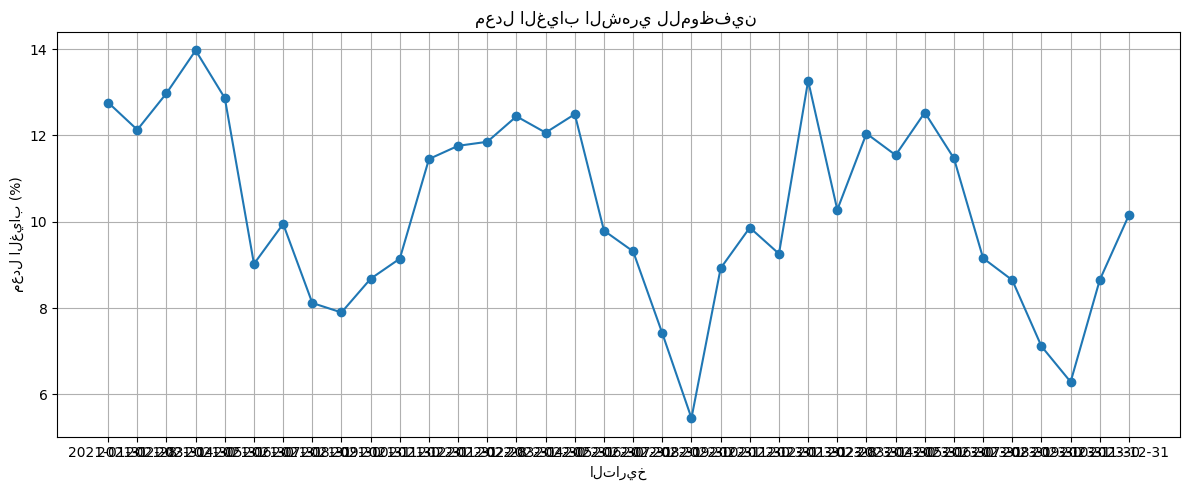

In [8]:
import matplotlib.pyplot as plt

# رسم السلسلة الزمنية
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['AbsenceRate'], marker='o', linestyle='-')
plt.title(fix_arabic_text('معدل الغياب الشهري للموظفين '))
plt.xlabel(fix_arabic_text('التاريخ'))
plt.ylabel(fix_arabic_text('معدل الغياب (%)'))
plt.grid(True)
plt.tight_layout()
plt.show()


## 4) Seasonal decomposition (Trend, Seasonality, Residual)

The chapter demonstrates additive decomposition with a 12-month seasonal period.

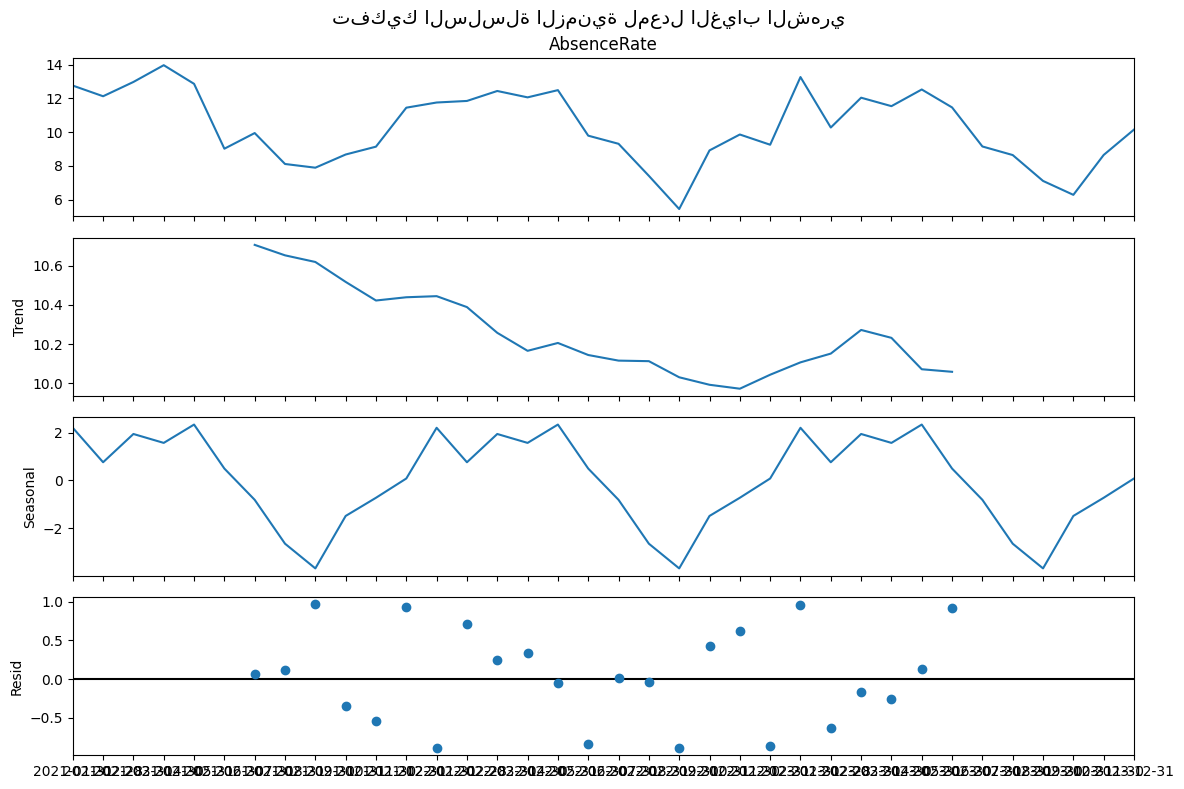

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# تطبيق تفكيك السلسلة الزمنية
decomposition = seasonal_decompose(df['AbsenceRate'], model='additive', period=12)

# عرض النتائج بالرسم
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle(fix_arabic_text('تفكيك السلسلة الزمنية لمعدل الغياب الشهري'), fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## 5) Stationarity check with ADF test

Augmented Dickey–Fuller (ADF) test is used to evaluate stationarity.

In [10]:

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['AbsenceRate'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print('The series is stationary.')
else:
    print('The series is not stationary.')


ADF Statistic: -4.162097414753707
p-value: 0.0007633002694171854
The series is stationary.


### Optional: Differencing (if the series is not stationary)

The chapter notes that differencing may be used until stationarity is achieved.

In [11]:

# Optional differencing example
# Uncomment if you need it.

# df_diff = df['AbsenceRate'].diff().dropna()
# result_diff = adfuller(df_diff)
# print('ADF Statistic (diff):', result_diff[0])
# print('p-value (diff):', result_diff[1])


## 6) ACF & PACF plots

These plots help propose initial ARIMA parameters (p and q).

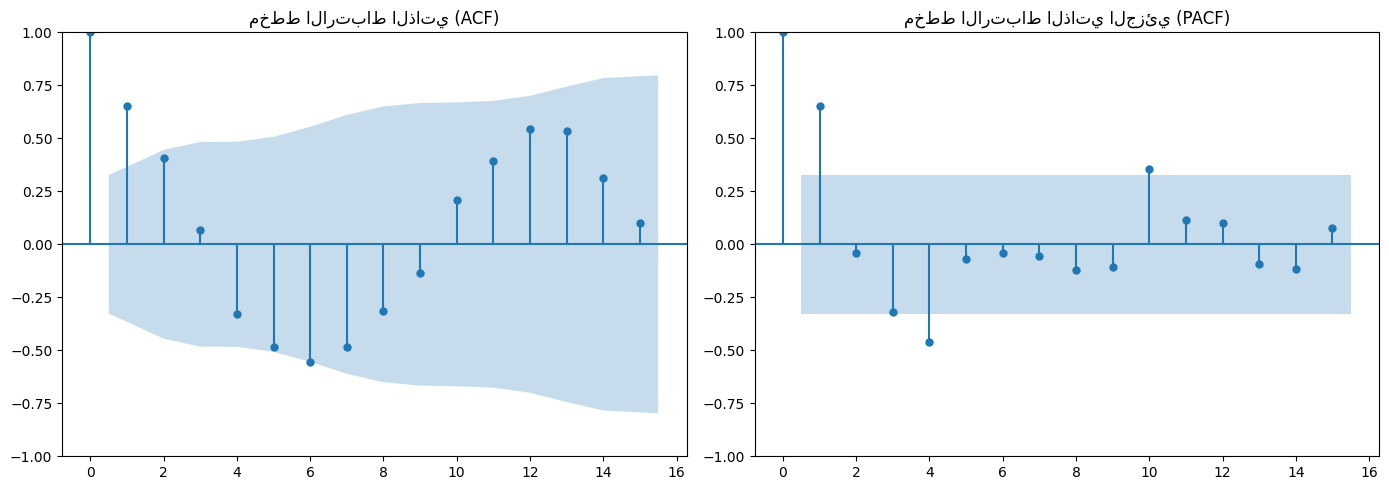

In [12]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_acf(df['AbsenceRate'], lags=15, ax=plt.gca(), title=fix_arabic_text('مخطط الارتباط الذاتي (ACF)'))

plt.subplot(1, 2, 2)
plot_pacf(df['AbsenceRate'], lags=15, ax=plt.gca(), title=fix_arabic_text('مخطط الارتباط الذاتي الجزئي (PACF)'))

plt.tight_layout()
plt.show()


## 7) Fit an ARIMA model (initial)

The chapter first tries ARIMA(2,0,3).

In [13]:

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['AbsenceRate'], order=(2, 0, 3))
result = model.fit()
print(result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            AbsenceRate   No. Observations:                   36
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 -55.130
Date:                Fri, 16 Jan 2026   AIC                            124.260
Time:                        11:53:23   BIC                            135.345
Sample:                    01-31-2021   HQIC                           128.129
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3037      0.180     57.315      0.000       9.951      10.656
ar.L1          1.7381      0.012    141.240      0.000       1.714       1.762
ar.L2         -0.9996      0.008   -122.492      0.0

## 8) Fit a simpler ARIMA model

The chapter then tries a simplified ARIMA(1,0,0).

In [14]:

model_simple = ARIMA(df['AbsenceRate'], order=(1, 0, 0))
result_simple = model_simple.fit()
print(result_simple.summary())


                               SARIMAX Results                                
Dep. Variable:            AbsenceRate   No. Observations:                   36
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -67.649
Date:                Fri, 16 Jan 2026   AIC                            141.298
Time:                        11:53:27   BIC                            146.049
Sample:                    01-31-2021   HQIC                           142.957
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4130      0.745     13.971      0.000       8.952      11.874
ar.L1          0.6623      0.123      5.376      0.000       0.421       0.904
sigma2         2.4703      0.711      3.475      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


## 9) In-sample predictions and comparison plot

Generate predictions over the observed period and compare actual vs predicted.

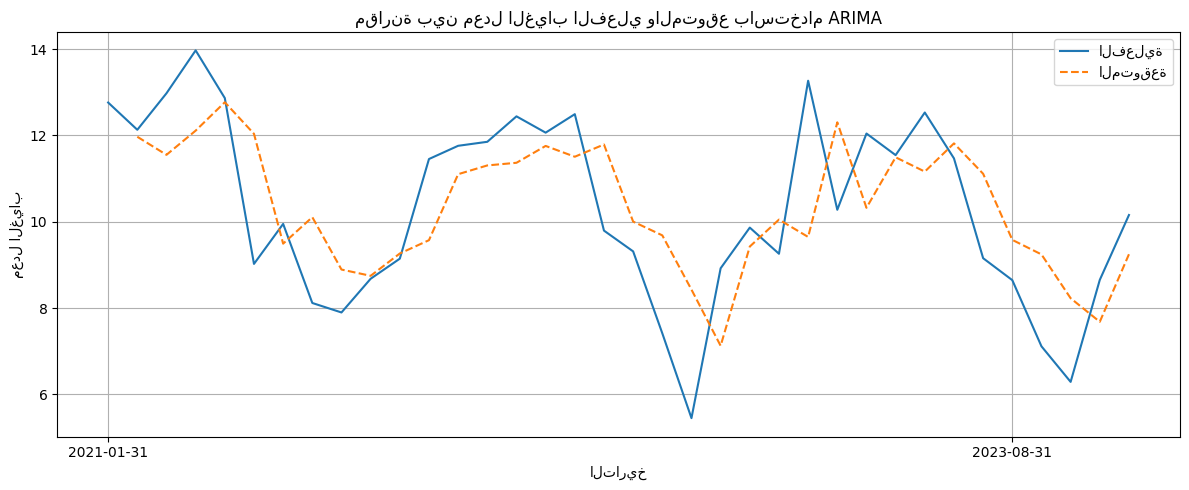

In [15]:

# Use the simplified model by default (as in the chapter narrative)
# You may switch to `result` if you prefer the initial model.

df = df.copy()
df['Predicted'] = result_simple.predict(start=1, end=len(df))

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['AbsenceRate'], label=fix_arabic_text('الفعلية'))
plt.plot(df.index, df['Predicted'], label=fix_arabic_text('المتوقعة'), linestyle='--')

plt.title(text_arabic_fix('مقارنة بين معدل الغياب الفعلي والمتوقع باستخدام ARIMA'))
plt.xlabel(fix_arabic_text('التاريخ'))
plt.ylabel(fix_arabic_text('معدل الغياب'))

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 10) Forecast the next 6 months with ARIMA

Forecast future values (out-of-sample).

In [16]:

forecast_arima = result_simple.forecast(steps=6)
print(forecast_arima)


2024-01-31    10.243015
2024-02-29    10.300415
2024-03-31    10.338431
2024-04-30    10.363609
2024-05-31    10.380285
2024-06-30    10.391329
Freq: ME, Name: predicted_mean, dtype: float64


## 11) SARIMA model (seasonal ARIMA)

The chapter demonstrates SARIMA via `SARIMAX` with seasonal period 12.

In [17]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    df['AbsenceRate'],
    order=(1, 0, 0),
    seasonal_order=(1, 0, 0, 12)
)

sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        AbsenceRate   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -70.792
Date:                            Fri, 16 Jan 2026   AIC                            147.583
Time:                                    11:53:38   BIC                            152.334
Sample:                                01-31-2021   HQIC                           149.242
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9732      0.045     21.613      0.000       0.885       1.061
ar.S.L12       0.4081      0.240   

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


## 12) Compare ARIMA vs SARIMA predictions

Plot actual series alongside ARIMA and SARIMA in-sample predictions.

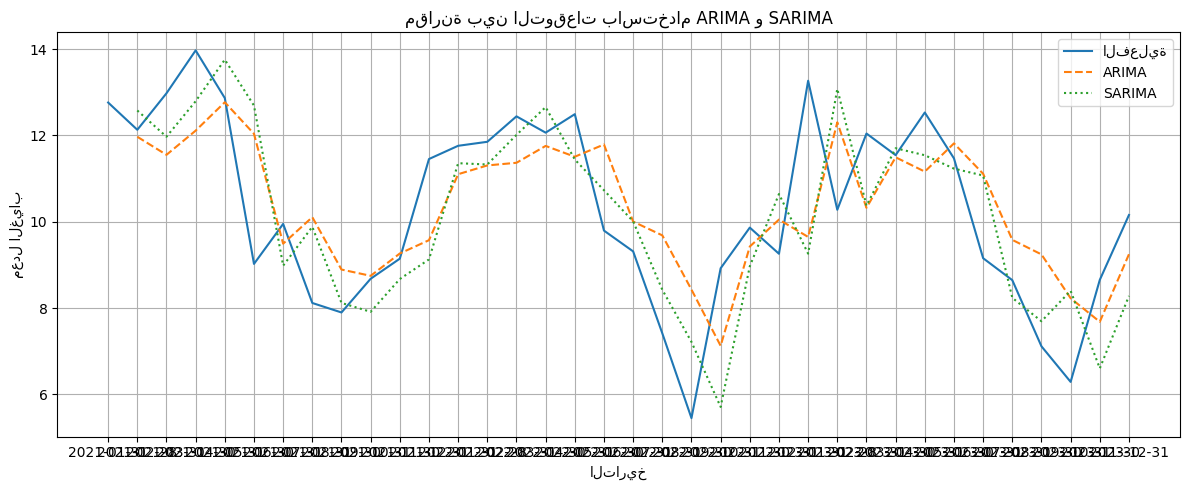

In [18]:

# SARIMA in-sample predictions

df['SARIMA_Predicted'] = sarima_result.predict(start=1, end=len(df))

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['AbsenceRate'], label=fix_arabic_text('الفعلية'))
plt.plot(df.index, df['Predicted'], linestyle='--', label='ARIMA')
plt.plot(df.index, df['SARIMA_Predicted'], linestyle=':', label='SARIMA')

plt.title(fix_arabic_text('مقارنة بين التوقعات باستخدام ARIMA و SARIMA'))
plt.xlabel(fix_arabic_text('التاريخ'))
plt.ylabel(fix_arabic_text('معدل الغياب'))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 13) Prophet model

Prophet requires the input columns `ds` (dates) and `y` (values).

In [19]:

from prophet import Prophet

# Prepare data for Prophet
# Note: if your index is not parsed as datetime, convert it.

df_prophet = df.reset_index()[['Date', 'AbsenceRate']].rename(columns={'Date': 'ds', 'AbsenceRate': 'y'})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

model_prophet = Prophet(yearly_seasonality=True)
model_prophet.fit(df_prophet)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 14) Add holidays (Saudi Arabia) and refit Prophet

The chapter illustrates adding Eid al-Fitr, Eid al-Adha, and National Day dates.

In [20]:

holidays = pd.DataFrame({
    'ds': pd.to_datetime([
        '2021-05-13',  # Eid al-Fitr 2021
        '2022-05-02',  # Eid al-Fitr 2022
        '2023-04-21',  # Eid al-Fitr 2023
        '2021-07-20',  # Eid al-Adha 2021
        '2022-07-09',  # Eid al-Adha 2022
        '2023-06-27',  # Eid al-Adha 2023
        '2021-09-23',  # National Day
        '2022-09-23',
        '2023-09-23'
    ]),
    'holiday': [
        'EidAlFitr', 'EidAlFitr', 'EidAlFitr',
        'EidAlAdha', 'EidAlAdha', 'EidAlAdha',
        'SaudiNationalDay', 'SaudiNationalDay', 'SaudiNationalDay'
    ]
})

model_prophet_h = Prophet(holidays=holidays, yearly_seasonality=True)
model_prophet_h.fit(df_prophet)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 15) Prophet forecast for the next 6 months

Generate a future dataframe and obtain out-of-sample forecasts.

In [21]:

future = model_prophet_h.make_future_dataframe(periods=6, freq='M')
forecast = model_prophet_h.predict(future)

last_date = df_prophet['ds'].max()
future_forecast = forecast[forecast['ds'] > last_date]

print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


           ds       yhat  yhat_lower  yhat_upper
36 2024-01-31  13.864762   13.209808   14.560131
37 2024-02-29  11.409186   10.709669   12.076438
38 2024-03-31  11.939385   11.297616   12.649930
39 2024-04-30  13.849133   13.213179   14.511285
40 2024-05-31  12.201243   11.520986   12.936765
41 2024-06-30   7.008036    6.316226    7.645998


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


## 16) ARIMA vs Prophet: metrics (MAE, RMSE)

The chapter compares predictive accuracy via MAE and RMSE.
To make this operational, we align in-sample predictions for both models.

In [22]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- ARIMA in-sample predictions (aligned) ---
arima_pred = df['Predicted'].astype(float).values
actual = df['AbsenceRate'].astype(float).values

# --- Prophet in-sample predictions ---
# Prophet prediction for historical dates
forecast_hist = model_prophet_h.predict(df_prophet[['ds']])
prophet_pred = forecast_hist['yhat'].values

# Metrics
arima_mae = mean_absolute_error(actual[1:], arima_pred[1:])
arima_rmse = np.sqrt(mean_squared_error(actual[1:], arima_pred[1:]))

prophet_mae = mean_absolute_error(actual, prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(actual, prophet_pred))

print(f"ARIMA  - MAE: {arima_mae:.3f}, RMSE: {arima_rmse:.3f}")
print(f"Prophet- MAE: {prophet_mae:.3f}, RMSE: {prophet_rmse:.3f}")


ARIMA  - MAE: 1.274, RMSE: 1.566
Prophet- MAE: 0.422, RMSE: 0.526


## 17) Visual comparison: Actual vs ARIMA vs Prophet

This final plot mirrors the chapter’s visual comparison.

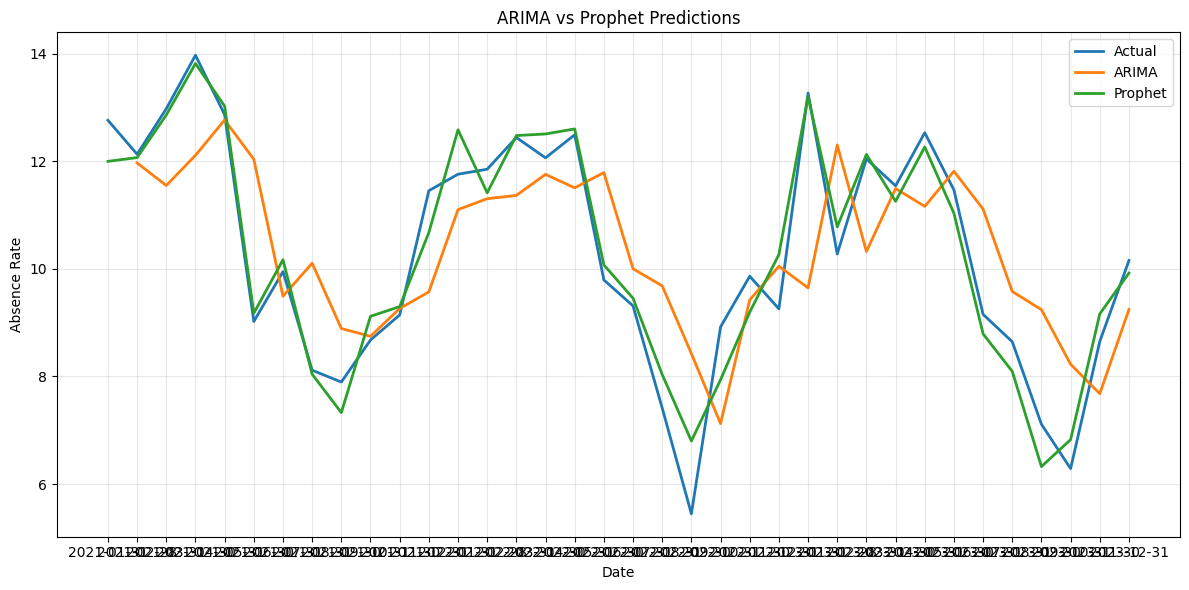

In [23]:

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AbsenceRate'], label='Actual', linewidth=2)
plt.plot(df.index, arima_pred, label='ARIMA', linewidth=2)
plt.plot(df.index, prophet_pred, label='Prophet', linewidth=2)

plt.title('ARIMA vs Prophet Predictions')
plt.xlabel('Date')
plt.ylabel('Absence Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
